In [1]:
# Définition des fonctions permettant le chargement des fichiers audios et le tracé des spectrogrammes

import os, sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import librosa as lb
import seaborn as sns
from os import listdir
from os.path import isfile, join

class File_charge:
    """
    La classe File_charge permet d'instancier un objet de type dataframe contenant les chemins d'accès des fichiers audio
    contenus dans chaque sous dossier du dataset
    
    Paramètres:
                path : Chemin d'accès au répetoire des fichiers audio
                expemple : path = "C:/Users/romua/Documents/Formation_data_scientist/ASD/dataset/fan/train/"    
    """
    def __init__(self, path):
        self.path = path 
        
    def load_file(self):
        """
        La fonction load_file retourne un dataframe constituer des chemins d'accès aux fichiers audio contenu 
        dans un sous dossier du dataset
        
        """
        
        dirs = os.listdir(self.path)

        df = list()
        for dir in dirs:
            df.append((self.path+"/"+dir))

        df = pd.DataFrame(df, columns = ['audio_file'])
        #df = df.reset_index()
        return  df

def load_audio(audio_path):
    return lb.load(audio_path, sr=None)

def logMelSpectrogram(audio, params, fe):
    stfts = lb.stft(audio,n_fft = int(params['n_fft']),hop_length = int(params["frame_step"]),center = False).T
    power_spectrograms = np.real(stfts * np.conj(stfts))
    linear_to_mel_weight_matrix = lb.filters.mel(sr=fe,n_fft=int(params['n_fft']) + 1,n_mels=params['num_mel_bins'],
                                fmin=params['lower_edge_hertz'],fmax=params['upper_edge_hertz']).T
    mel_spectrograms = np.tensordot(power_spectrograms,linear_to_mel_weight_matrix, 1)
    return (np.log(mel_spectrograms + 1e-8).astype(np.float16))

In [3]:
#Défintion des dataframes qui permettront de connaitre les caractéristiques de chaque extrait

df_train = File_charge("C:/Users/Quasarlight/Desktop/Formation data/Projet/Donnees_sonores/ToyCar/train/")
df_train = df_train.load_file()

df_train['machine_type'] = (df_train.iloc[:,0]).apply(lambda x: x.split('/')[7])
df_train['machine_id'] = ((df_train.iloc[:,0]).apply(lambda x: x.split('/')[-1]))
df_train['machine_id'] = (df_train['machine_id']).apply(lambda x: x.split('_')[2])

df_test = File_charge("C:/Users/Quasarlight/Desktop/Formation data/Projet/Donnees_sonores/ToyCar/test/")
df_test = df_test.load_file()

df_test['machine_type'] = (df_test.iloc[:,0]).apply(lambda x: x.split('/')[7])
df_test['machine_id'] = ((df_test.iloc[:,0]).apply(lambda x: x.split('/')[-1]))
df_test['machine_id'] = (df_test['machine_id']).apply(lambda x: x.split('_')[2])
df_test['machine_class'] = (df_test.iloc[:,0]).apply(lambda x: x.split('/')[-1])
df_test['machine_class'] = (df_test['machine_class']).apply(lambda x: x.split('_')[0])
df_test['label'] = df_test['machine_class'].replace( {'normal': True , 'anomaly': False}) 


"""
Définir l'emplacement où sera sauvegardé le Dataframe pour l'entraînement
"""

df_train.to_csv('ToyCar_train_img_normalized/fichier_ToyCar_train.csv')
df_test.to_csv('ToyCar_test_img_normalized/fichier_ToyCar_test.csv')

#Importation des extraits audio

toycars_train = list()
for i in range(len(df_train)):
    toycars_train.append(load_audio(df_train.iloc[i,0])[0])  

toycars_test=list()
for i in range(len(df_test)):
    toycars_test.append(load_audio(df_test.iloc[i, 0])[0])

In [13]:
#Conversion des extrait audio en images 

"""
Choisir le nombres de pixels de chaque image
"""
pixels=32

_,fe_tc = lb.load('ToyCar/train/normal_id_01_00000000.wav', sr=None)
params = {'n_fft': 1024,'frame_step': 512,'lower_edge_hertz': 0,'upper_edge_hertz': 8000,'num_mel_bins': 128}
nb_img=len(logMelSpectrogram(toycars_train[0], params, fe_tc))//pixels

for k in np.arange(len(toycars_train)):
    for i in np.arange(0,nb_img):      
        np.savetxt("ToyCar_train_img_normalized/id_"+df_train['machine_id'][k]+"/extrait_"+str(k)+"_img"+str(i+1)+".txt",(logMelSpectrogram(toycars_train[k], params, fe_tc)[np.max([pixels*i,0]):(pixels*(i+1)),:])/18+1, delimiter =', ')

print(len(toycars_train)*nb_img,'images de',pixels,'pixels ont été sauvegardées') 

40000 images de 32 pixels ont été sauvegardées


In [14]:
#Idem pour le set de test

for k in np.arange(len(toycars_test)):
    for i in np.arange(0,nb_img):
        np.savetxt("ToyCar_test_img_normalized/id_"+df_test['machine_id'][k]+"/extrait_"+df_test['machine_class'][k]+str(k)+ "_img" +str(i+1)+".txt",(logMelSpectrogram(toycars_test[k], params, fe_tc)[np.max([pixels*i,0]):(pixels*(i+1)),:])/18+1, delimiter =', ')


(0.0, 32.0, 128.0, 0.0)

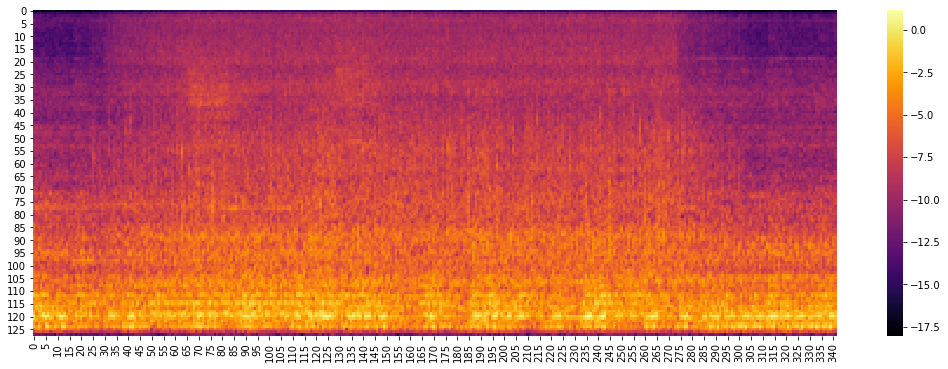

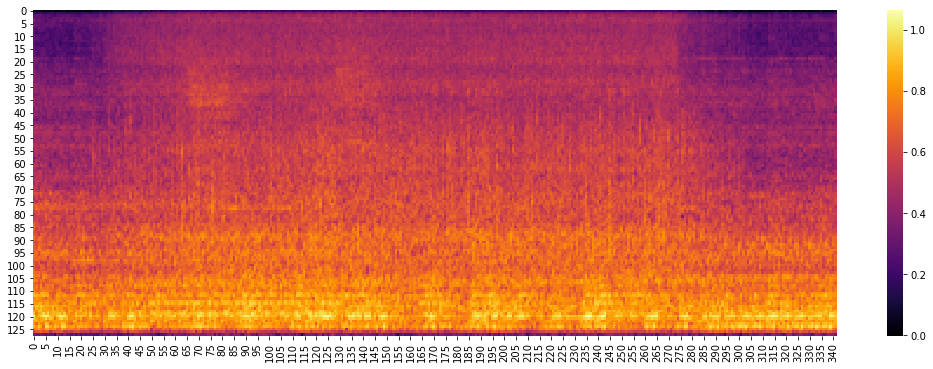

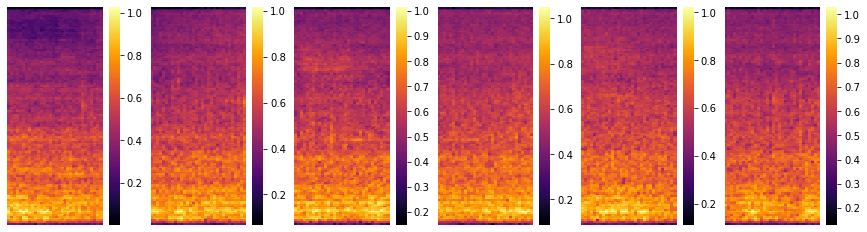

In [15]:
plt.figure(figsize=(18,6))
sns.heatmap(np.rot90(logMelSpectrogram(toycars_train[10], params, fe_tc)), cmap='inferno')
plt.figure(figsize=(18,6))
sns.heatmap(np.rot90(logMelSpectrogram(toycars_train[10], params, fe_tc))/18+1, cmap='inferno')
plt.figure(figsize=(15,4))
plt.subplot(161)
sns.heatmap(np.rot90(logMelSpectrogram(toycars_train[10], params, fe_tc)[np.max([pixels*0,0]):(pixels*(1)),:])/18+1, cmap='inferno')
plt.axis('off')
plt.subplot(162)
sns.heatmap(np.rot90(logMelSpectrogram(toycars_train[10], params, fe_tc)[np.max([pixels*1,0]):(pixels*(2)),:])/18+1, cmap='inferno')
plt.axis('off')
plt.subplot(163)
sns.heatmap(np.rot90(logMelSpectrogram(toycars_train[10], params, fe_tc)[np.max([pixels*2,0]):(pixels*(3)),:])/18+1, cmap='inferno')
plt.axis('off')
plt.subplot(164)
sns.heatmap(np.rot90(logMelSpectrogram(toycars_train[10], params, fe_tc)[np.max([pixels*3,0]):(pixels*(4)),:])/18+1, cmap='inferno')
plt.axis('off')
plt.subplot(165)
sns.heatmap(np.rot90(logMelSpectrogram(toycars_train[10], params, fe_tc)[np.max([pixels*4,0]):(pixels*(5)),:])/18+1, cmap='inferno')
plt.axis('off')
plt.subplot(166)
sns.heatmap(np.rot90(logMelSpectrogram(toycars_train[10], params, fe_tc)[np.max([pixels*5,0]):(pixels*(6)),:])/18+1, cmap='inferno')
plt.axis('off')